# 第11回講義 演習

**今回のnotebookは[Colaboratory](https://colab.research.google.com/?hl=ja)（以下Colab）での利用を想定しています。**  
Colabで利用する場合は```ランタイム -> ランタイムのタイプを変更```からGPUを選択してください。

In [0]:
import gym
import numpy as np
import tensorflow as tf

import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt

from collections import deque

目次

課題. Deep Q-Network (DQN)によるCartPoleの攻略

1. OpenAI Gymの環境構築と可視化 (CartPole)
2. Q NetworkとTarget Networkの実装
3. Experience Replayの実装
4. 学習

# 課題. Deep Q-Network (DQN)によるCartPoleの攻略

### 1. OpenAI Gymの環境構築と可視化 (CartPole)

強化学習のトイタスクとしてよく利用されるのがCartpoleです。台車に棒が縦に乗った状態で始まり、倒れようとする棒を台車を左右に動かすことで倒れないように保つゲームです。   
今回はOpenAI GymというOpenAIが開発している強化学習研究・開発のためのプラットフォームを利用して、 CartpoleをDQNで攻略します。

まず、ランダムに行動を選択させて画面が出力されることを確認します。

- `gym.make('ゲームの名前')`: 環境を構築
- `env.reset()`: エピソードを開始
- `env.render()`: ゲーム画面の出力
- `env.action_space.sample()`: 行動をランダムに選択
- `next_state, reward, terminal, _ = env.step(action)`: 行動を環境に渡し, 次の状態, 報酬, エピソードの終了についての情報を取得

In [2]:
# Colab上では以下を実行してください
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install JSAnimation

  Stored in directory: /root/.cache/pip/wheels/3c/c2/b2/b444dffc3eed9c78139288d301c4009a42c0dd061d3b62cead
Successfully built JSAnimation


In [3]:
# Colab上では以下を実行してください
from pyvirtualdisplay import Display
pydisplay = Display(visible=0, size=(400, 300))
pydisplay.start()

W0628 04:50:46.151132 140696443852672 abstractdisplay.py:151] xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
import gym
from IPython import display

env = gym.make('CartPole-v0') # ゲーム環境の構築
frames = []
for episode in range(10):
    state = env.reset()
    terminal = False
    while not terminal:
        env.render() # ゲーム画面の出力

        action = env.action_space.sample() # 行動をランダムに選択
        next_state, reward, terminal, _ = env.step(action) # 行動を実行し、 次の状態、 報酬、 終端か否かの情報を取得
        
        screen = env.render(mode='rgb_array')
        frames.append(screen)
env.close()

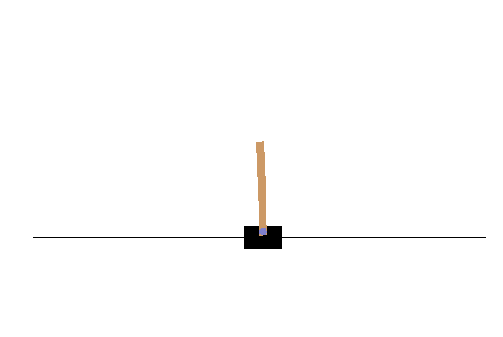

In [5]:
# 結果の確認
from JSAnimation.IPython_display import display_animation
from IPython.display import HTML

plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
patch = plt.imshow(frames[0])
plt.axis('off')
  
def animate(i):
    patch.set_data(frames[i])
    
anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
HTML(anim.to_jshtml())

In [0]:
env.close() #画面出力の終了

状態や行動は以下のように設定されています。
- state: サイズ(4,)のnp.ndarray
    - (カートの位置, カートの速度, ボールの角度, ボールの角速度)
- action:
    - 0: カートを左に移動させる
    - 1: カートを右に移動させる
- reward:
    - （常に）1.0
- terminal:
    - False: エピソード継続
    - True: エピソード終了 (ポールが倒れた)

### 2. Q NetworkとTarget Networkの実装

状態は4次元ベクトル、行動の候補数は2つなので、4->16->16->16->2のユニットを持つQ NetworkとTarget Networkを実装します。

In [0]:
tf.reset_default_graph()

n_states = 4
n_actions = 2

initializer = tf.variance_scaling_initializer()

x_state = tf.placeholder(tf.float32, [None, n_states])

def original_network(x):
    with tf.variable_scope('Original', reuse=tf.AUTO_REUSE):
        h = tf.layers.Dense(units=16, activation=tf.nn.elu, kernel_initializer=initializer)(x)
        h = tf.layers.Dense(units=16, activation=tf.nn.elu, kernel_initializer=initializer)(h)
        h = tf.layers.Dense(units=16, activation=tf.nn.elu, kernel_initializer=initializer)(h)
        y = tf.layers.Dense(units=n_actions, kernel_initializer=initializer)(h)
    return y

def target_network(x):
    with tf.variable_scope('Target', reuse=tf.AUTO_REUSE):
        h = tf.layers.Dense(units=16, activation=tf.nn.elu, kernel_initializer=initializer)(x)
        h = tf.layers.Dense(units=16, activation=tf.nn.elu, kernel_initializer=initializer)(h)
        h = tf.layers.Dense(units=16, activation=tf.nn.elu, kernel_initializer=initializer)(h)
        y = tf.layers.Dense(units=n_actions, kernel_initializer=initializer)(h)
    return y

q_original = original_network(x_state)
vars_original = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Original')

q_target = target_network(x_state)
vars_target = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Target')

Target Networkに対して、ネットワークの重みをコピーするオペレーションを実装します。

In [0]:
copy_ops = [var_target.assign(var_original) for var_target, var_original in zip(vars_target, vars_original)]
copy_weights = tf.group(*copy_ops)

訓練オペレーションを実装します。

In [0]:
t = tf.placeholder(tf.float32, [None])
x_action = tf.placeholder(tf.int32, [None])
q_value = tf.reduce_sum(q_original * tf.one_hot(x_action, n_actions), axis=1)

cost = tf.reduce_mean(tf.square(tf.subtract(t,q_value)))
optimizer = tf.train.AdamOptimizer()
train_ops = optimizer.minimize(cost)

### 3. Experience Replayの実装

Experience Replayを実現するため、経験した履歴を保存するReplayMemoryを実装します。

In [0]:
class ReplayMemory:
    def __init__(self, memory_size):
        self.memory_size = memory_size
        self.memory = deque([], maxlen = memory_size)
    
    def append(self, transition):
        self.memory.append(transition)
    
    def sample(self, batch_size):
        batch_indexes = np.random.randint(0, len(self.memory), size=batch_size).tolist()

        state      = np.array([self.memory[index]['state'] for index in batch_indexes])
        next_state = np.array([self.memory[index]['next_state'] for index in batch_indexes])
        reward     = np.array([self.memory[index]['reward'] for index in batch_indexes])
        action     = np.array([self.memory[index]['action'] for index in batch_indexes])
        terminal   = np.array([self.memory[index]['terminal'] for index in batch_indexes])
        
        return {'state': state, 'next_state': next_state, 'reward': reward, 'action': action, 'terminal': terminal}

学習を始める前にランダムに行動した履歴をReplayMemoryに事前に貯めておきます。

In [0]:
memory_size = 50000 #メモリーサイズ
initial_memory_size = 500 #事前に貯める経験数

In [0]:
env = gym.make('CartPole-v0')

replay_memory = ReplayMemory(memory_size)

step = 0

while True:
    state = env.reset()
    terminal = False
    
    while not terminal:
        action = env.action_space.sample() # ランダムに行動を選択
        
        next_state, reward, terminal, _ = env.step(action) # 状態、報酬、終了判定の取得
        
        transition = {
            'state': state,
            'next_state': next_state,
            'reward': reward,
            'action': action,
            'terminal': int(terminal)
        }
        replay_memory.append(transition) # 経験の記憶

        state = next_state
        
        step += 1
    
    if step >= initial_memory_size:
        break

### 4. 学習

ε-greedy方策を実装します。

In [0]:
eps_start = 1.0
eps_end = 0.1
n_steps = 10000
def get_eps(step):
    return max(0.1, (eps_end - eps_start) / n_steps * step + eps_start)

各種ハイパーパラメータを設定します。

In [0]:
gamma = 0.99
target_update_interval = 1000 #重みの更新間隔
batch_size = 32
n_episodes = 300
step = 0
init = tf.global_variables_initializer()

n_episodesの数だけ学習を行います。

In [15]:
with tf.Session() as sess:
    init.run()
    copy_weights.run() # 初期重みのコピー
    for episode in range(n_episodes):
        state = env.reset()
        terminal = False

        total_reward = 0
        total_q_max = []
        while not terminal:
            q = q_original.eval(feed_dict={x_state: state[None]}) # Q値の計算
            total_q_max.append(np.max(q))

            eps = get_eps(step) # εの更新
            if np.random.random() < eps:
                action = env.action_space.sample() # （ランダムに）行動を選択
            else:
                action = np.argmax(q) # 行動を選択
            next_state, reward, terminal, _ = env.step(action) # 状態、報酬、終了判定の取得
            reward = np.sign(reward)
            total_reward += reward # エピソード内の報酬を更新

            transition = {
                'state': state,
                'next_state': next_state,
                'reward': reward,
                'action': action,
                'terminal': int(terminal)
            }
            replay_memory.append(transition) # 経験の記憶
            
            batch = replay_memory.sample(batch_size) # 経験のサンプリング
            q_target_next = q_target.eval(feed_dict={x_state: batch['next_state']}) # ターゲットQ値の計算
            t_value = batch['reward'] + (1 - batch['terminal']) * gamma * q_target_next.max(1)
            
            train_ops.run(feed_dict = {x_state: batch['state'], x_action: batch['action'], t: t_value}) # 訓練オペレーション

            state = next_state

            if (step + 1) % target_update_interval == 0:
                copy_weights.run() # 一定期間ごとに重みをコピー

            step += 1

        if (episode + 1) % 10 == 0:
            print('Episode: {}, Reward: {}, Q_max: {:.4f}, eps: {:.4f}'.format(episode + 1, total_reward, np.mean(total_q_max), eps))
    
    # 学習させたネットワークでTest
    frames = []
    state = env.reset()
    terminal = False

    total_reward = 0
    while not terminal:
        img = env.render(mode="rgb_array")
        frames.append(img)

        q = q_original.eval(feed_dict={x_state: state[None]})
        action = np.argmax(q)

        next_state, reward, terminal, _ = env.step(action)
        total_reward += reward

        state = next_state
    
    print('Test Reward:', total_reward)

Episode: 10, Reward: 28.0, Q_max: 1.1578, eps: 0.9753
Episode: 20, Reward: 17.0, Q_max: 1.1602, eps: 0.9493
Episode: 30, Reward: 13.0, Q_max: 1.1841, eps: 0.9343
Episode: 40, Reward: 16.0, Q_max: 1.1752, eps: 0.9158
Episode: 50, Reward: 23.0, Q_max: 2.1178, eps: 0.8881
Episode: 60, Reward: 21.0, Q_max: 2.1534, eps: 0.8704
Episode: 70, Reward: 19.0, Q_max: 2.1030, eps: 0.8460
Episode: 80, Reward: 51.0, Q_max: 2.0562, eps: 0.8276
Episode: 90, Reward: 31.0, Q_max: 3.0304, eps: 0.8069
Episode: 100, Reward: 21.0, Q_max: 3.0460, eps: 0.7858
Episode: 110, Reward: 18.0, Q_max: 2.8956, eps: 0.7685
Episode: 120, Reward: 30.0, Q_max: 2.9663, eps: 0.7458
Episode: 130, Reward: 45.0, Q_max: 3.9327, eps: 0.7223
Episode: 140, Reward: 46.0, Q_max: 4.0094, eps: 0.6880
Episode: 150, Reward: 37.0, Q_max: 3.9651, eps: 0.6553
Episode: 160, Reward: 28.0, Q_max: 4.7512, eps: 0.6105
Episode: 170, Reward: 57.0, Q_max: 5.0133, eps: 0.5668
Episode: 180, Reward: 102.0, Q_max: 5.9102, eps: 0.4929
Episode: 190, Rewa

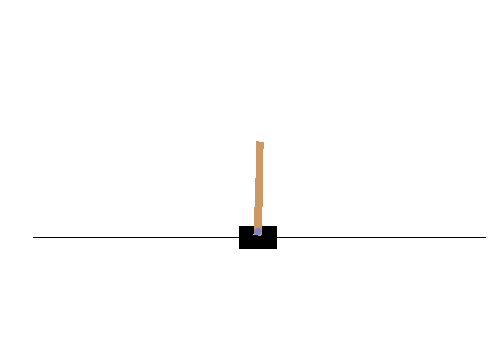

In [16]:
# 結果の確認
plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
patch = plt.imshow(frames[0])
plt.axis('off')
    
anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
HTML(anim.to_jshtml())

In [0]:
env.close() # 画面出力の終了